In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from numpy.linalg import norm
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [35]:
# параметры распределений
mu0 = np.array([-2.,1.])
mu1 = np.array([3.,-0.5])

In [36]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [37]:
d0 = torch.distributions.MultivariateNormal(torch.tensor(mu0.data), torch.eye(2))
d1 = torch.distributions.MultivariateNormal(torch.tensor(mu1.data), torch.eye(2))

In [38]:
d0.sample((10,))

tensor([[-1.6980, -1.3051],
        [-0.9531,  1.0700],
        [-1.2549,  2.8857],
        [-2.6195,  0.1433],
        [-2.1971,  0.7686],
        [-1.4673,  1.5856],
        [-1.3522,  1.4560],
        [-1.4610, -0.7041],
        [-2.7969,  0.9886],
        [-2.7354,  1.8919]])

In [39]:
d1.sample((10,))

tensor([[ 2.9075, -0.5467],
        [ 3.5735, -0.4287],
        [ 5.0699,  0.2841],
        [ 3.0299,  0.1094],
        [ 2.9237,  0.0579],
        [ 3.1697, -1.8326],
        [ 2.7154, -0.9828],
        [ 2.8683, -0.4950],
        [ 1.5013,  0.2040],
        [ 3.0168,  0.1205]])

In [40]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([-0.4578,  0.1460]), tensor(0.4862)]


In [ ]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = torch.sigmoid(layer(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = torch.sigmoid(layer(x))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: 1.531850
Ошибка после 1 итераций: 0.483262
Ошибка после 2 итераций: 0.271718
Ошибка после 3 итераций: 0.194702
Ошибка после 4 итераций: 0.155626
Ошибка после 5 итераций: 0.130886
Ошибка после 6 итераций: 0.114603
Ошибка после 7 итераций: 0.102490
Ошибка после 8 итераций: 0.093228
Ошибка после 9 итераций: 0.086259
Ошибка после 10 итераций: 0.080464
Ошибка после 11 итераций: 0.075302
Ошибка после 12 итераций: 0.071277
Ошибка после 13 итераций: 0.067500


In [30]:
x_scale = np.linspace(-10, 10, 5000)
d0_pdf = stats.norm.pdf(x_scale, norm(mu0, ord=2), 1) 
d1_pdf = stats.norm.pdf(x_scale, norm(mu1, ord=2), 1)
x_tensor = torch.tensor(np.linspace(-10, 10, 10000).reshape(-1, 2), dtype=torch.float)
print(x_tensor.shape)
with torch.no_grad():
    dist = torch.sigmoid(layer(x_tensor)).numpy()
ratio = d1_pdf / (d1_pdf + d0_pdf)

torch.Size([5000, 2])


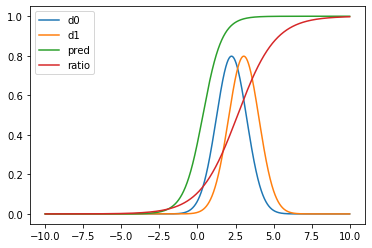

In [31]:
plt.plot(x_scale, d0_pdf*2, label='d0') # умножение на 2 для красоты графиков, на распределения не влияет
plt.plot(x_scale, d1_pdf*2, label='d1')
plt.plot(x_scale, dist.flatten(), label='pred')
plt.plot(x_scale, ratio, label='ratio')
plt.legend();